<a href="https://colab.research.google.com/github/vibhorbhatt777/Style-transfer-Pytorch/blob/main/Style_Transfer_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pillow


In [3]:
#import resoorces
%matplotlib inline
from PIL import Image # pillow to get the image
from io import BytesIO # transfer image into bytes
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests # for sending req to internet
from torchvision import transforms, models

In [5]:
#load the VGG19 Model(features)
#vgg19.features --> which are all the convolutional and POlling layer
#vgg19.classifier --> which are three linear classifier at the end
# Feature is used to train our model
#classifier is used to predict the output of the model
#in this i dont want ot classisfy the image

In [6]:
vgg = models.vgg19(pretrained= True).features
#freeze all parameters since we only optimizing the target image
for i in vgg.parameters():
  i.requires_grad_(False)
  #whn the model is trained and to correct the features i have to go for backtracking
  #take the gradient of the mistake i found

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 66.8MB/s]


In [7]:
#move the model to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device)
vgg.to(device)
#thsi is our model output

cpu


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
#Helper function
# load contnet and style image
def load_image(img_path , max_size=400, shape=None):
  '''Load in and transform an imaage , making sure the image
  is<=400 pixels in the x-y dims.'''
  if 'http' in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image = Image.open(img_path).convert('RGB')

    #large image will slow down processing
    if max(image.size) > max_size:
      size = max_size
    else:
      size = max(image.size)

    if shape is not None:
      size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.496),
                             (0.229,0.224,0.225))])

      #discard the transparent , alpha channel (thats the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [9]:
#load in content image and style image
content = load_image('/content/drive/MyDrive/style-transfer/images/cat.jpeg').to(device)
#resize style to match content image , make code easier
style = load_image('/content/drive/MyDrive/style-transfer/images/wave.jpeg',shape=content.shape[-2:]).to(device)

In [10]:
#helper function to unnormailize an image
# and convert from  tensor image to numpy image for dispaly
def im_convert(tensor):
    """  Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image  = image * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)

    return image

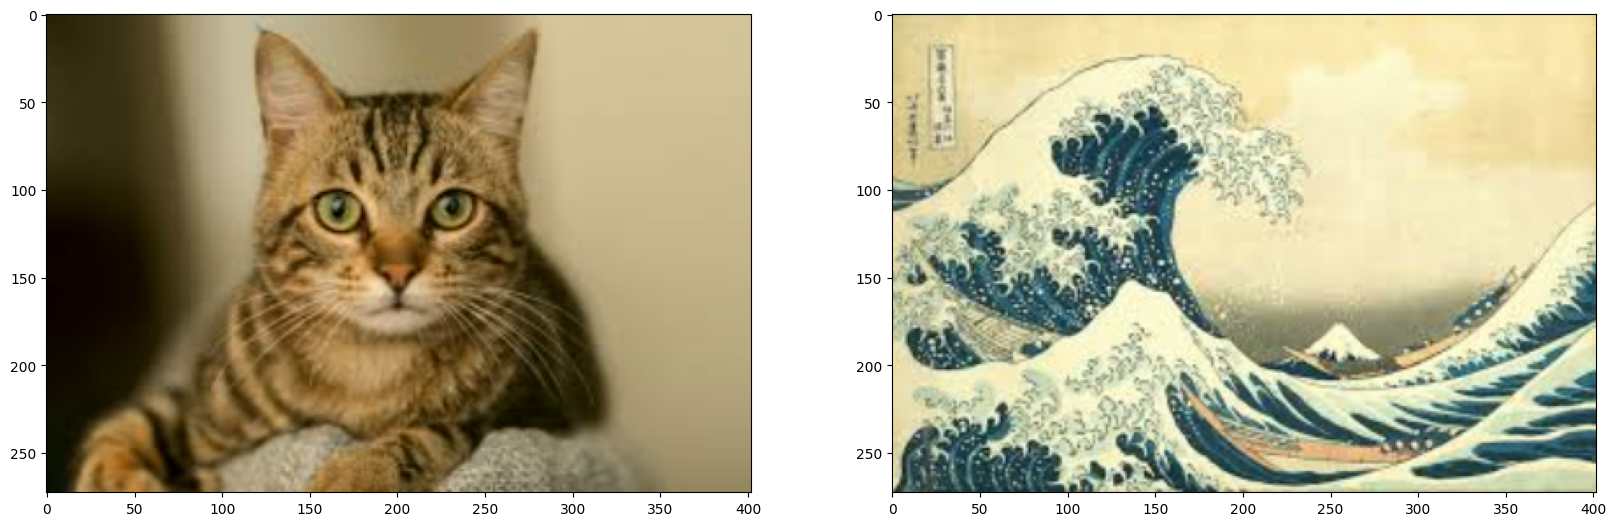

In [11]:
#display the image
fig , (ax1 , ax2) = plt.subplots(1,2, figsize=(20,10))
#content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [12]:
#VGG19 TO GET THE CONTENT AND STYLE REP of an image we have to pass an image forward through vgg19 network until we get th desired layers
# and then we get the output layers


In [13]:
#print out vgg19 structure so you can see th names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
#from ast import NotEq
#content and style features
def get_features(image,model,layers= None):
    """Run an image frard through model and get the feature for
     a set of layers , defaults layers are of vggnet matching
    """
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19':'conv4_1',
                  '21': 'conv4_2', ## content reprsentation
                  '28': 'conv5_1'}
    features = {}
    X = image
    #model ._modules is a dictionary holding each modules in the model
    for name , layer in model._modules.items():
        X = layer(X)
        if name in layers:
           features[layers[name]] = X
    return features


In [15]:
#Gram Matrix
#the output of every convolutional is tensor with batch size  , depth , height , width
#calaculate gram matrix
def gram_matrix(tensor):
    _,d, h, w = tensor.size()
    tensor = tensor.view(d,h*w)
    #calculate gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram



In [16]:
#put it all together
content_features = get_features(content,vgg)
style_features = get_features(style,vgg)
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [17]:
#loss and weight
#weight for each style layer
# weight earlier layer more will result in larger style artiacts
#notice we are execute conv4_2 our content rep
style_weights = {'conv1_1':1.,
                 'conv2_1':0.75,
                 'conv3_1':0.2,
                 'conv4_1':0.2,
                 'conv5_1':0.2}
content_weight = 1 # alpha
style_weight = 1e6 # beta


Total loss:  28680464.0


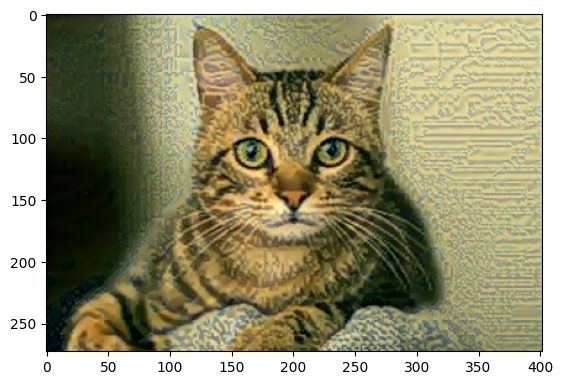

Total loss:  16589992.0


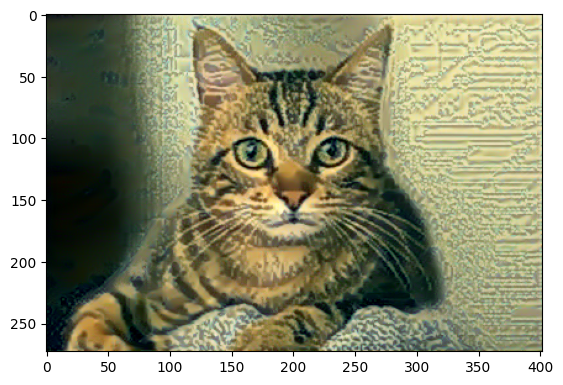

Total loss:  12144887.0


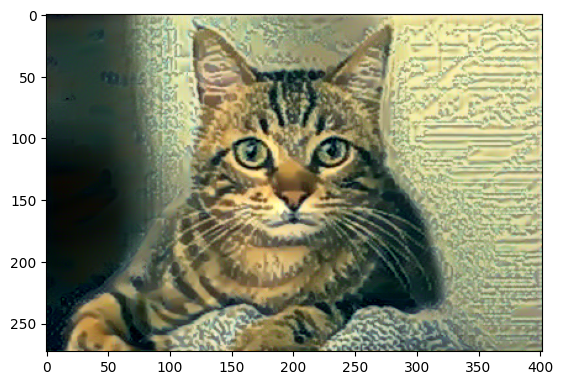

Total loss:  9545903.0


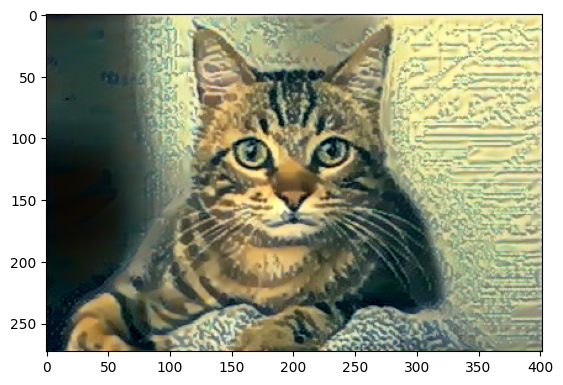

Total loss:  7607508.5


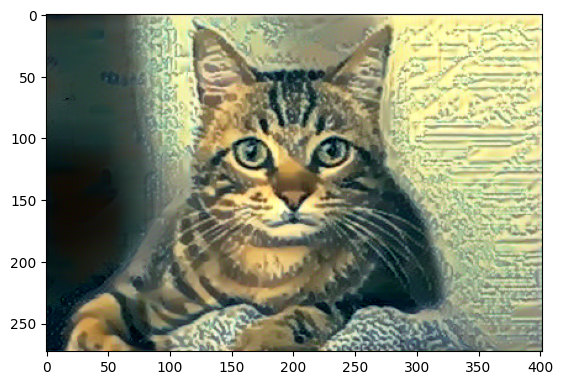

Total loss:  6079002.5


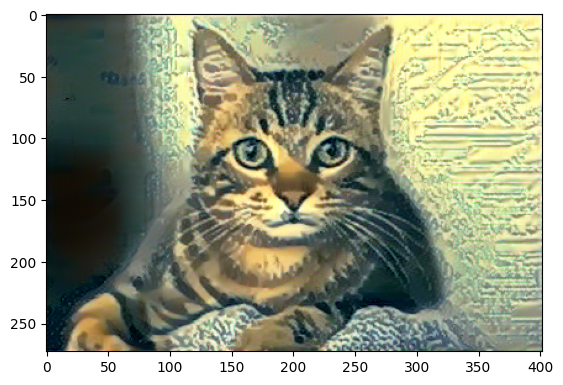

Total loss:  4883423.0


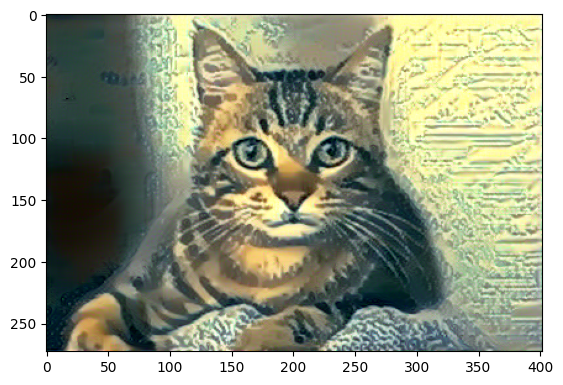

Total loss:  3961331.25


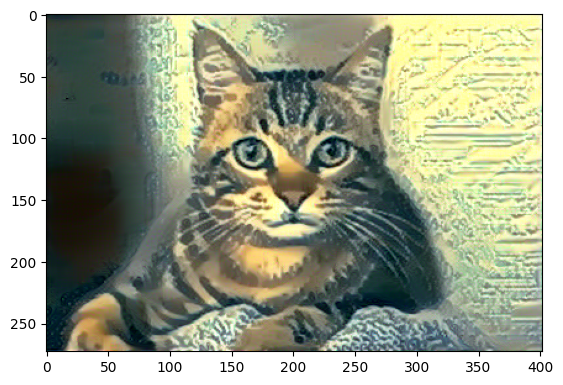

Total loss:  3251041.5


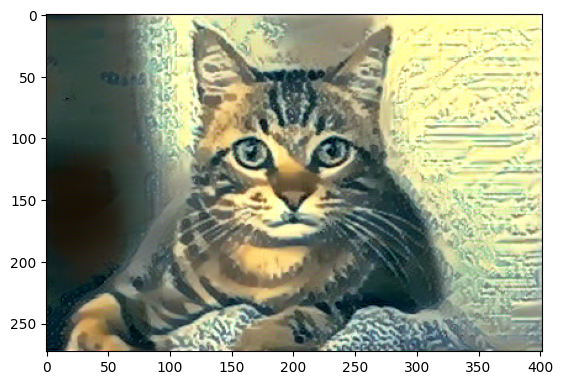

Total loss:  2708370.5


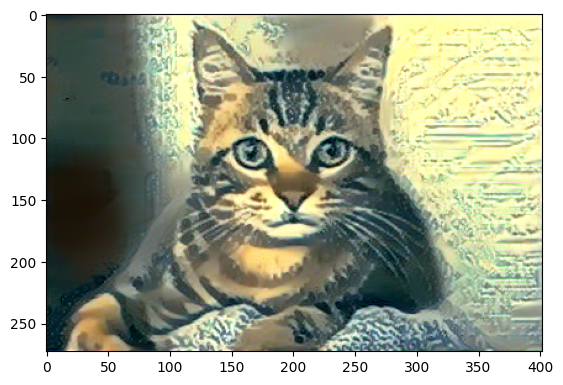

KeyboardInterrupt: 

In [19]:
#for dispaly the target image  , intermittently
show_every = 100
# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

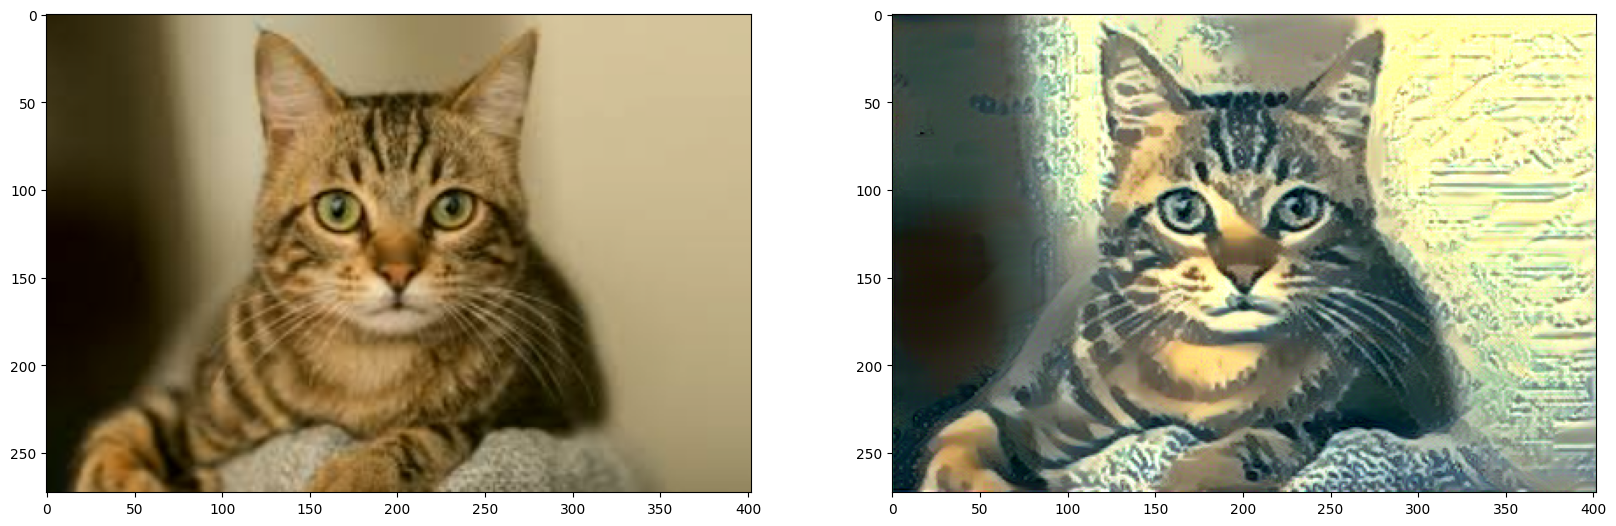

In [20]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))